# Descrição

Treinar um classificador linear para identificar dígitos da base MNIST. Mostrar um amadurecimento com relação ao treino, como por exemplo:
 - Avaliar diferentes valores para hiperparâmetros (taxa de aprendizagem, lambda, número de épocas)
 - Plotar loss
 - Plotar a matriz de confusão

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from keras.datasets import mnist

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cuda


In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train.shape, y_train.shape, x_test.shape, y_test.shape

11490434/11490434 [==============================] - 1s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [9]:
def cross_entropy_loss(y_pred, y, W, l2_lambda):
    # Calcular softmax
    exp_logits = torch.exp(y_pred)
    softmax = exp_logits / exp_logits.sum(dim=1, keepdim=True)

    # Calcular a perda de entropia cruzada
    n = y_pred.size(0)
    log_softmax = torch.log(softmax)
    loss = -log_softmax[range(n), y].mean()

    # Adicionar regularização L2
    l2_reg = l2_lambda * (W ** 2).sum()
    loss += l2_reg

    return loss

In [10]:
def classificador_linear(x, y, n_features, n_classes, n_epochs, learning_rate, l2_lambda):
  print('Iniciando treinamento...')
  print(f' device: {device}')
  print(f' n_epochs: {n_epochs}')
  print(f' learning_rate: {learning_rate}')
  print(f' l2_lambda: {l2_lambda}')

  torch.manual_seed(0)

  W = (torch.tensor(0.1, device=device) * torch.randn(n_features, n_classes, device=device, dtype=torch.float))
  W.requires_grad=True
  b = torch.zeros(n_classes, device=device, dtype=torch.float, requires_grad=True)

  losses = []

  for epoch in range(n_epochs):
    # Forward
    logits = x @ W + b

    loss = cross_entropy_loss(logits, y, W, l2_lambda) # Calcula a perda
    losses.append(loss.item())

    # Backward
    loss.backward()

    # Atualiza os pesos
    with torch.no_grad():
      W -= learning_rate * W.grad
      b -= learning_rate * b.grad

      W.grad.zero_()
      b.grad.zero_()

    if epoch % 100 == 0: # Printa o loss a cada 100 epochs
      print(f'Epoch {epoch} / {n_epochs}, Lr: {learning_rate}, Loss: {loss.item()}')

  return W, b, losses

In [11]:
# Funções para predição e teste do classificador linear
def linear_classifier_predict(x, W, b):
    logits = x @ W + b
    return torch.argmax(logits, dim=1)

def linear_classifier_testing(x, y, W, b):
    predicted_y = linear_classifier_predict(x, W, b)
    test_accuracy = torch.sum(predicted_y == y) * 100 / float(y.shape[0])
    print(f'Test accuracy = {test_accuracy.item()}')
    return test_accuracy.item()

In [12]:
n_classes = 10 # Número de classes do dataset 0 ~ 9
n_features = 28 * 28 # Número de features de cada imagem do dataset (imagens em níveis de cinza)

x_train = torch.tensor((x_train.reshape(60000, n_features) / 255) - 0.5, device=device, dtype=torch.float)
y_train = torch.tensor(y_train, device=device, dtype=torch.long)
x_test = torch.tensor((x_test.reshape(10000, n_features) / 255) - 0.5, device=device, dtype=torch.float)
y_test = torch.tensor(y_test, device=device, dtype=torch.long)

In [ ]:
# Teste de treino
W, b, losses = classificador_linear(x_train, y_train, n_features, n_classes, 1000, 0.01, 0.001)

Epoch 0 / 1000, Lr: 0.01, Loss: 3.6517744064331055
Epoch 100 / 1000, Lr: 0.01, Loss: 2.378863573074341
Epoch 200 / 1000, Lr: 0.01, Loss: 2.37853741645813
Epoch 300 / 1000, Lr: 0.01, Loss: 2.3782119750976562
Epoch 400 / 1000, Lr: 0.01, Loss: 2.3778884410858154
Epoch 500 / 1000, Lr: 0.01, Loss: 2.377565622329712
Epoch 600 / 1000, Lr: 0.01, Loss: 2.377244472503662
Epoch 700 / 1000, Lr: 0.01, Loss: 2.376924514770508
Epoch 800 / 1000, Lr: 0.01, Loss: 2.376605749130249
Epoch 900 / 1000, Lr: 0.01, Loss: 2.3762881755828857


In [25]:
# Avaliar o modelo no conjunto de teste
test_accuracy = linear_classifier_testing(x_test, y_test, W, b)

Test accuracy = 11.34999942779541


# Teste com diferentes taxas de aprendizagens

In [13]:
n_epochs = 2000
l2_lambda = 0.001

n_classes = 10 # Número de classes do dataset 0 ~ 9
n_features = 28 * 28 # Número de features de cada imagem do dataset (imagens em níveis de cinza)

learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75]

train_losses = []
test_accuracies = []

for learning_rate in learning_rates:
  W, b, losses = classificador_linear(x_train, y_train, n_features, n_classes, n_epochs, learning_rate, l2_lambda)
  test_accuracy = linear_classifier_testing(x_test, y_test, W, b)

  train_losses.append(losses)
  test_accuracies.append(test_accuracy)

Iniciando treinamento...
 device: cuda
 n_epochs: 2000
 learning_rate: 0.001
 l2_lambda: 0.001
Epoch 0 / 2000, Lr: 0.001, Loss: 3.2234182357788086
Epoch 100 / 2000, Lr: 0.001, Loss: 2.536661148071289
Epoch 200 / 2000, Lr: 0.001, Loss: 2.3682162761688232
Epoch 300 / 2000, Lr: 0.001, Loss: 2.2592835426330566
Epoch 400 / 2000, Lr: 0.001, Loss: 2.163912057876587
Epoch 500 / 2000, Lr: 0.001, Loss: 2.0754635334014893
Epoch 600 / 2000, Lr: 0.001, Loss: 1.9930334091186523
Epoch 700 / 2000, Lr: 0.001, Loss: 1.9163377285003662
Epoch 800 / 2000, Lr: 0.001, Loss: 1.845126748085022
Epoch 900 / 2000, Lr: 0.001, Loss: 1.779128074645996
Epoch 1000 / 2000, Lr: 0.001, Loss: 1.7180447578430176
Epoch 1100 / 2000, Lr: 0.001, Loss: 1.6615594625473022
Epoch 1200 / 2000, Lr: 0.001, Loss: 1.609344244003296
Epoch 1300 / 2000, Lr: 0.001, Loss: 1.561068058013916
Epoch 1400 / 2000, Lr: 0.001, Loss: 1.5164053440093994
Epoch 1500 / 2000, Lr: 0.001, Loss: 1.4750449657440186
Epoch 1600 / 2000, Lr: 0.001, Loss: 1.43669

## Plotando os resultados dos treinamentos com diferentes taxas de aprendizagem:

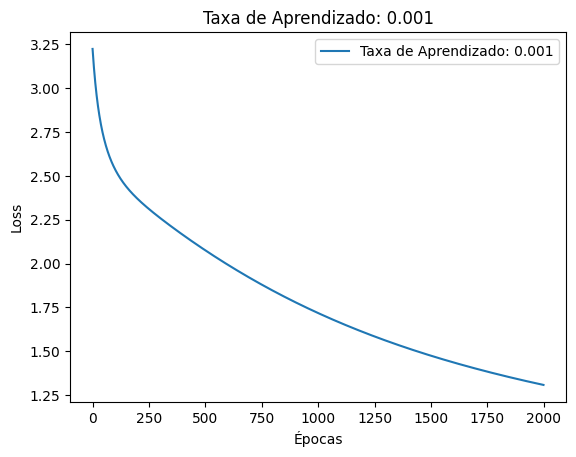

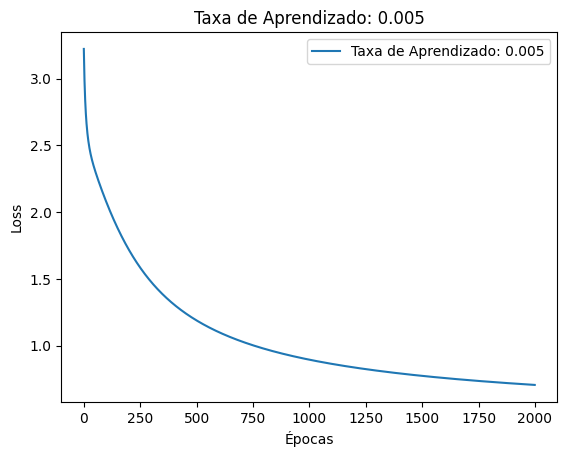

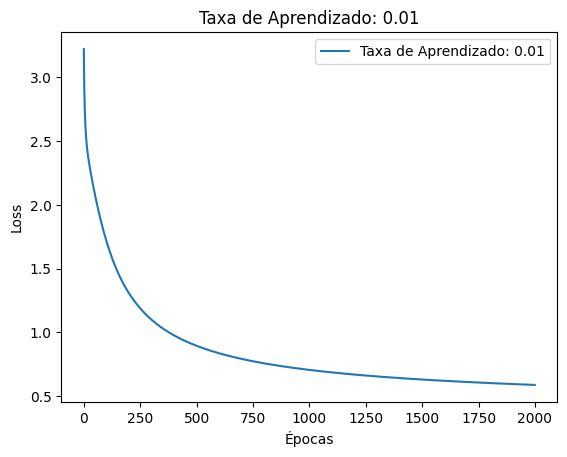

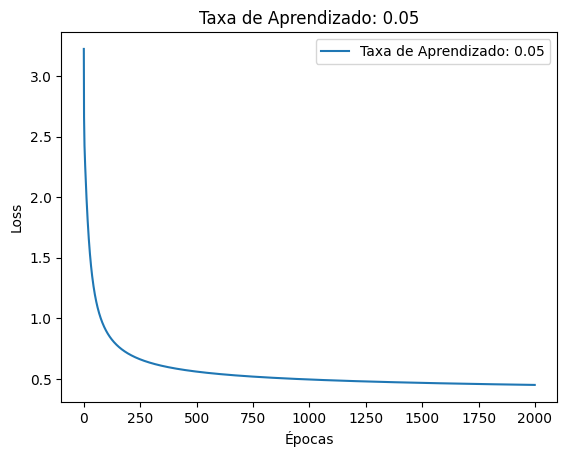

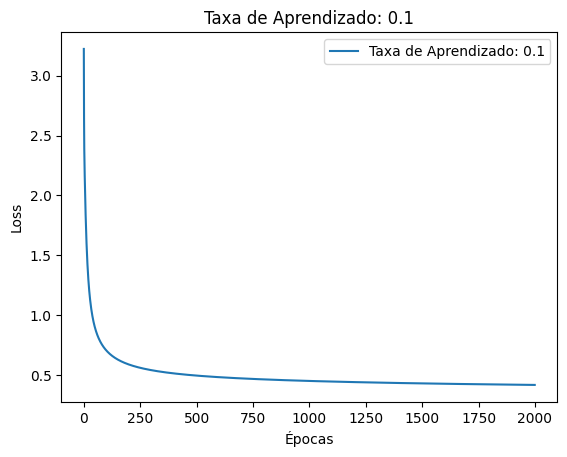

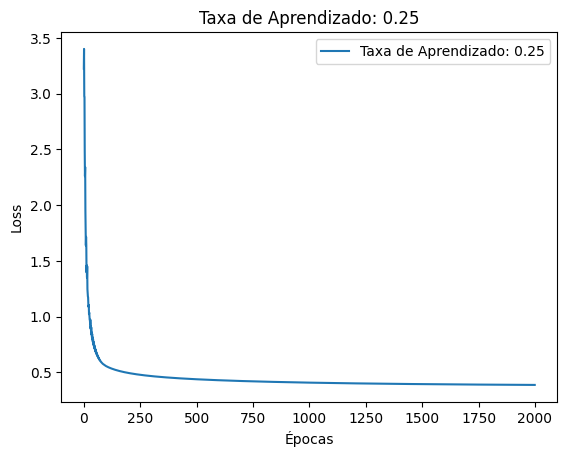

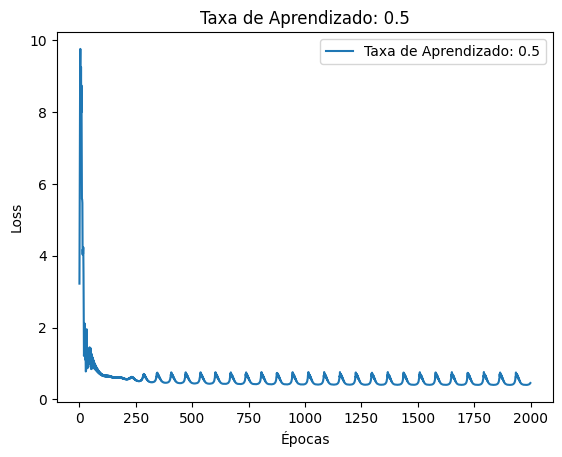

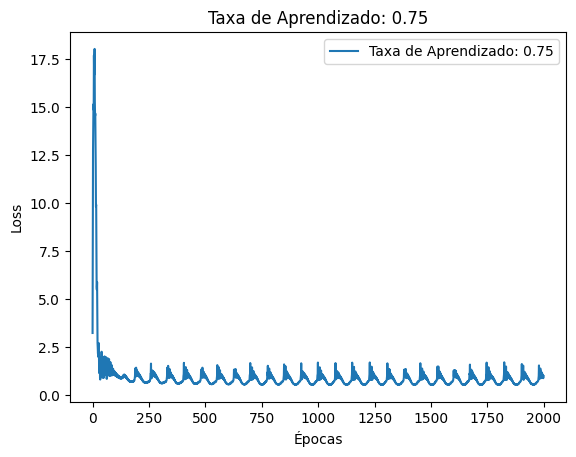

In [14]:
for i, learning_rate in enumerate(learning_rates):
  plt.plot(train_losses[i], label=f'Taxa de Aprendizado: {learning_rate}')
  plt.xlabel('Épocas')
  plt.ylabel('Loss')
  plt.title(f'Taxa de Aprendizado: {learning_rate}')
  plt.legend()
  plt.show()


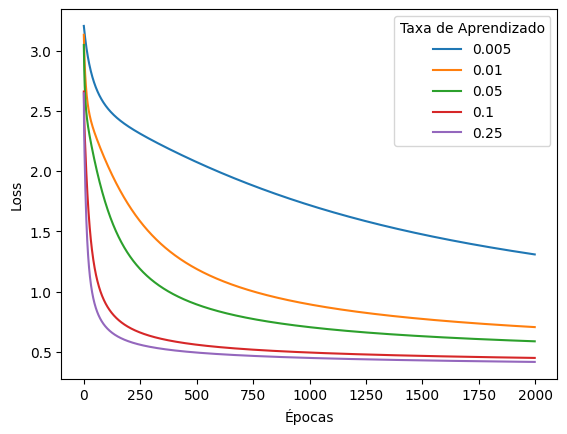

In [15]:
# Descartar dados de treinamento com learning_rate 0.001, 0.75 e 0.5
learning_rates = [0.005, 0.01, 0.05, 0.1, 0.25]

for i, learning_rate in enumerate(learning_rates):
  plt.plot(train_losses[i][1:], label=f'{learning_rate}')

plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend(title='Taxa de Aprendizado')
plt.show()



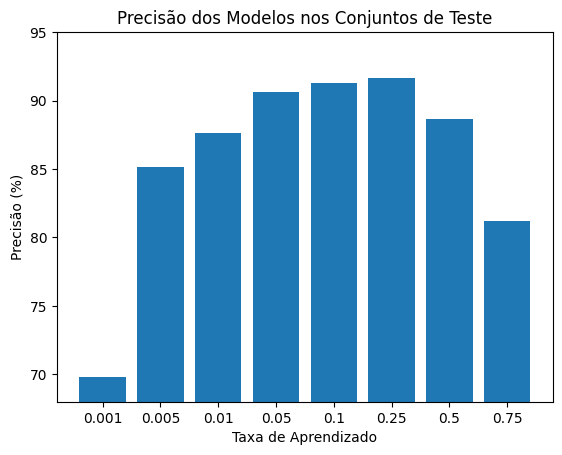

In [16]:
# Precisão dos modelos nos conjuntos de teste
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75]

labels = [f'{learning_rate}' for learning_rate in learning_rates]

plt.bar(labels, test_accuracies)
plt.ylim(68, 95)

plt.xlabel('Taxa de Aprendizado')
plt.ylabel('Precisão (%)')
plt.title('Precisão dos Modelos nos Conjuntos de Teste')
plt.show()


# Teste com diferentes L2_Lambda

In [17]:
n_epochs = 2000
best_learning_rate = 0.25

n_classes = 10 # Número de classes do dataset 0 ~ 9
n_features = 28 * 28 # Número de features de cada imagem do dataset (imagens em níveis de cinza)

l2_lambdas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

train_losses = []
test_accuracies = []

for l2_lambda in l2_lambdas:
  W, b, losses = classificador_linear(x_train, y_train, n_features, n_classes, n_epochs, best_learning_rate, l2_lambda)
  test_accuracy = linear_classifier_testing(x_test, y_test, W, b)

  train_losses.append(losses)
  test_accuracies.append(test_accuracy)

Iniciando treinamento...
 device: cuda
 n_epochs: 2000
 learning_rate: 0.25
 l2_lambda: 0.0001
Epoch 0 / 2000, Lr: 0.25, Loss: 3.152891159057617
Epoch 100 / 2000, Lr: 0.25, Loss: 0.4699609577655792
Epoch 200 / 2000, Lr: 0.25, Loss: 0.4060949981212616
Epoch 300 / 2000, Lr: 0.25, Loss: 0.37792736291885376
Epoch 400 / 2000, Lr: 0.25, Loss: 0.36124494671821594
Epoch 500 / 2000, Lr: 0.25, Loss: 0.34994447231292725
Epoch 600 / 2000, Lr: 0.25, Loss: 0.3416687250137329
Epoch 700 / 2000, Lr: 0.25, Loss: 0.3352886140346527
Epoch 800 / 2000, Lr: 0.25, Loss: 0.3301866948604584
Epoch 900 / 2000, Lr: 0.25, Loss: 0.3259929120540619
Epoch 1000 / 2000, Lr: 0.25, Loss: 0.32247060537338257
Epoch 1100 / 2000, Lr: 0.25, Loss: 0.3194604218006134
Epoch 1200 / 2000, Lr: 0.25, Loss: 0.316850870847702
Epoch 1300 / 2000, Lr: 0.25, Loss: 0.31456124782562256
Epoch 1400 / 2000, Lr: 0.25, Loss: 0.31253188848495483
Epoch 1500 / 2000, Lr: 0.25, Loss: 0.31071722507476807
Epoch 1600 / 2000, Lr: 0.25, Loss: 0.30908215045

## Plotando os resultados dos treinamentos com diferentes l2_lambdas e learning_rate = 0.25

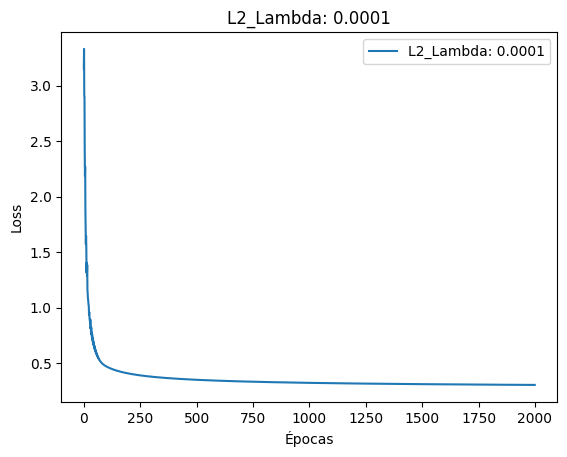

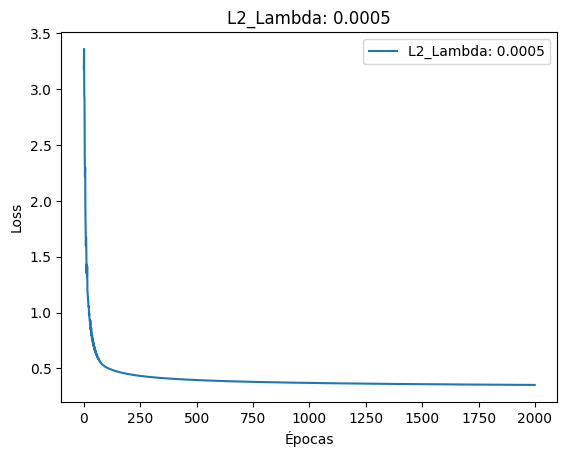

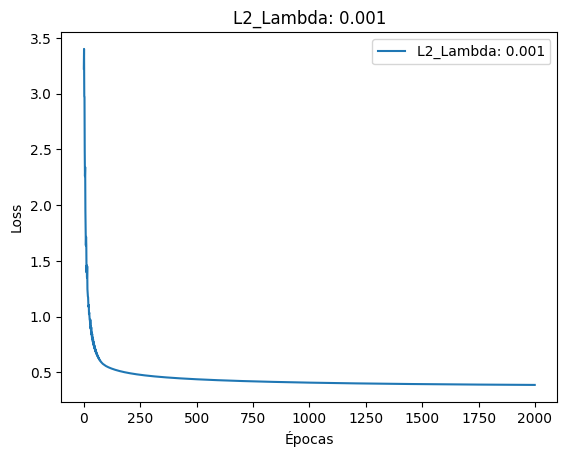

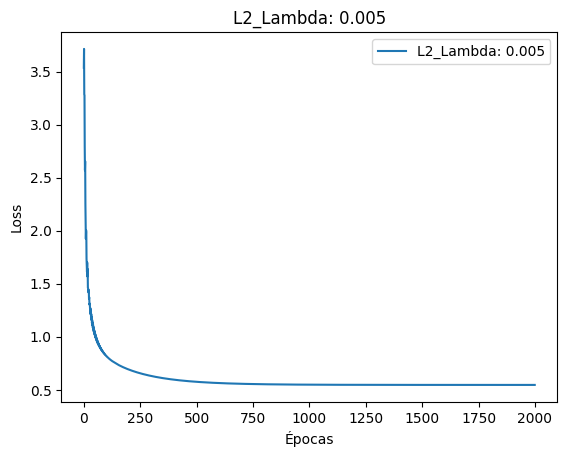

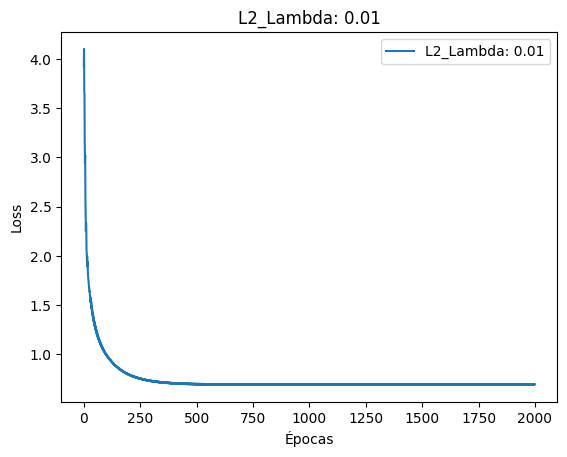

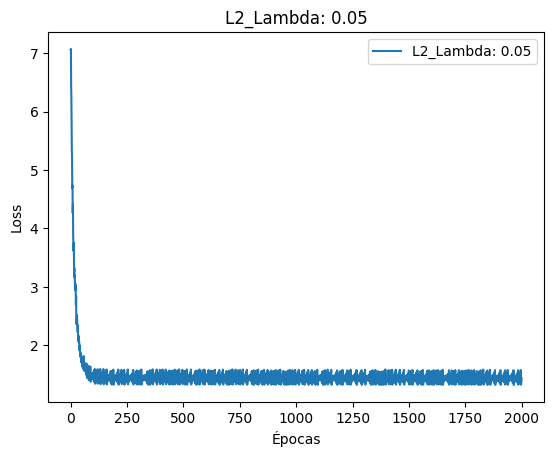

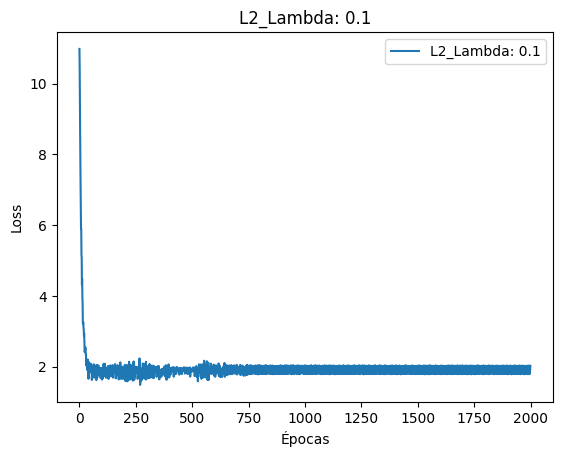

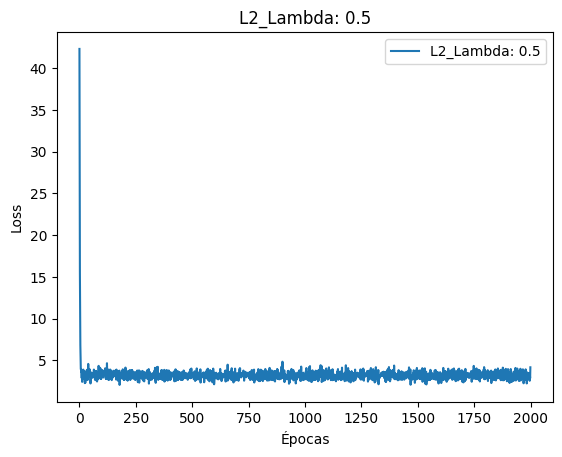

In [18]:
for i, l2_lambda in enumerate(l2_lambdas):
  plt.plot(train_losses[i], label=f'L2_Lambda: {l2_lambda}')
  plt.xlabel('Épocas')
  plt.ylabel('Loss')
  plt.title(f'L2_Lambda: {l2_lambda}')
  plt.legend()
  plt.show()

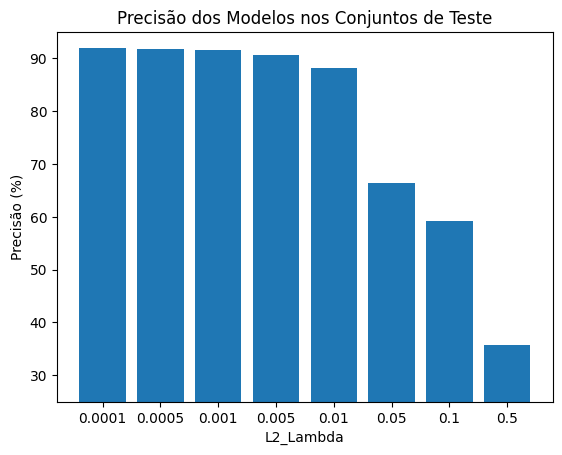

In [19]:
# Precisão dos modelos nos conjuntos de teste
labels = [f'{l2_lambda}' for l2_lambda in l2_lambdas]

plt.bar(labels, test_accuracies)
plt.ylim(25, 95)

plt.xlabel('L2_Lambda')
plt.ylabel('Precisão (%)')
plt.title('Precisão dos Modelos nos Conjuntos de Teste')
plt.show()

# Teste com melhor learning_rate e melhor l2_lambda

In [20]:
best_learning_rate = 0.25
best_l2_lambda = 0.0001

n_epochs = 15000

W, b, losses = classificador_linear(x_train, y_train, n_features, n_classes, n_epochs, best_learning_rate, best_l2_lambda)

Iniciando treinamento...
 device: cuda
 n_epochs: 15000
 learning_rate: 0.25
 l2_lambda: 0.0001
Epoch 0 / 15000, Lr: 0.25, Loss: 3.152891159057617
Epoch 100 / 15000, Lr: 0.25, Loss: 0.4699609577655792
Epoch 200 / 15000, Lr: 0.25, Loss: 0.4060949981212616
Epoch 300 / 15000, Lr: 0.25, Loss: 0.37792736291885376
Epoch 400 / 15000, Lr: 0.25, Loss: 0.36124494671821594
Epoch 500 / 15000, Lr: 0.25, Loss: 0.34994447231292725
Epoch 600 / 15000, Lr: 0.25, Loss: 0.3416687250137329
Epoch 700 / 15000, Lr: 0.25, Loss: 0.3352886140346527
Epoch 800 / 15000, Lr: 0.25, Loss: 0.3301866948604584
Epoch 900 / 15000, Lr: 0.25, Loss: 0.3259929120540619
Epoch 1000 / 15000, Lr: 0.25, Loss: 0.32247060537338257
Epoch 1100 / 15000, Lr: 0.25, Loss: 0.3194604218006134
Epoch 1200 / 15000, Lr: 0.25, Loss: 0.316850870847702
Epoch 1300 / 15000, Lr: 0.25, Loss: 0.31456124782562256
Epoch 1400 / 15000, Lr: 0.25, Loss: 0.31253188848495483
Epoch 1500 / 15000, Lr: 0.25, Loss: 0.31071722507476807
Epoch 1600 / 15000, Lr: 0.25, L

In [21]:
linear_classifier_testing(x_test, y_test, W, b)

Test accuracy = 92.43999481201172


92.43999481201172

## Resultados do treinamento com melhor l2_lambda e learning_rate

### Gráfico do loss ao longo do treinamento com muitas épocas

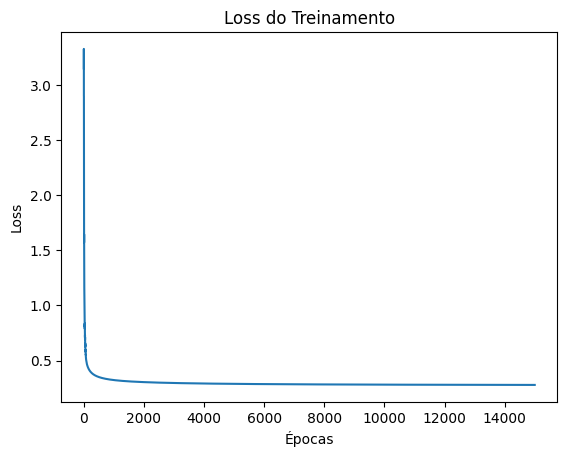

In [22]:
plt.plot(losses)
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss do Treinamento')
plt.show()

### Matriz de confusão do modelo treinado

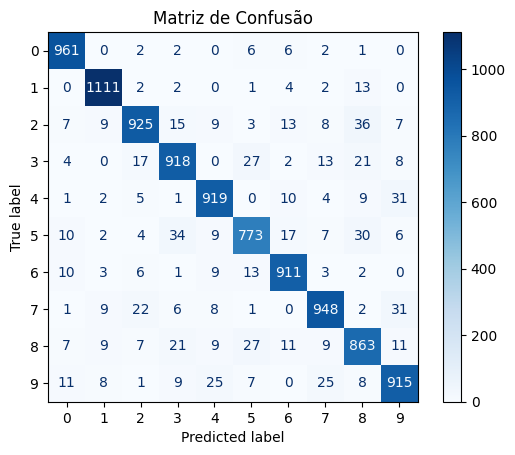

In [23]:
# Matriz de confusão
y_pred = linear_classifier_predict(x_test, W, b)
cm = confusion_matrix(y_test.cpu(), y_pred.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(n_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()